# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# ACCESS-NRI intake catalogue
import intake

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

### LOAD DATA

In [2]:
%%time

catalog = intake.cat.access_nri

# access to fs38 NCI project where the ACCESS-ESM-1.5 runs are stored
cmip6_fs38_datastore = catalog.search(name='cmip6_fs38').to_source()

# reduce to only ocean variables
cmip6_fs38_ocean_datastore = cmip6_fs38_datastore.search(realm=['ocean','ocnBgchem'], frequency=["mon"], source_id=["ACCESS-ESM1-5"], experiment_id=["historical"], version=["v.*"])


CPU times: user 10.4 s, sys: 935 ms, total: 11.3 s
Wall time: 11.8 s


In [4]:
%%time

cat_df = cmip6_fs38_ocean_datastore.df
#cat_df.head()

cat_df['variable_id'].unique()


CPU times: user 0 ns, sys: 13.9 ms, total: 13.9 ms
Wall time: 57 ms


array(['talk', 'volcello', 'po4', 'vmo', 'arag', 'msftyz', 'no3',
       'rlntds', 'agessc', 'dissic', 'bigthetao', 'friver', 'hfevapds',
       'masscello', 'o2', 'chl', 'talkos', 'dissicos', 'thetao', 'vo',
       'o2os', 'detoc', 'zooc', 'wmo', 'umo', 'dissicnatos', 'msftmz',
       'mfo', 'obvfsq', 'epc100', 'so', 'mlotst', 'zos', 'spco2', 'uo',
       'wo', 'msftbarot', 'htovovrt', 'no3os', 'hfbasinpmadv', 'tob',
       'chlos', 'sos', 'tos', 'bigthetaoga', 'sltovovrt', 'thetaoga',
       'wfo', 'po4os', 'htovgyre', 'soga', 'eparag100', 'rsntds', 'hfds',
       'evs', 'hflso', 'sltovgyre', 'msftyrho', 'fgco2nat', 'pso',
       'masso', 'hfsso', 'msftmrho', 'phycos', 'tauuo', 'fgco2', 'phynos',
       'fsitherm', 'hfsifrazil', 'dfeos', 'pbo', 'zostoga', 'intpp',
       'hfrainds', 'tosga', 'sfriver', 'spco2nat', 'tauvo', 'sosga',
       'volo', 'sob', 'fgo2', 'detocos', 'zoocos'], dtype=object)

## Filter for the variables we want

In [11]:
%%time

sst_df = cat_df[(cat_df['variable_id'] == "o2")]
sst_df.head()


CPU times: user 9.31 ms, sys: 10.2 ms, total: 19.5 ms
Wall time: 75.9 ms


,path,file_type,realm,frequency,table_id,project_id,institution_id,source_id,experiment_id,member_id,variable_id,grid_label,version,time_range
19,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r21i1p1f1/Omon/o2/gn/v20200922/o2_Omon_ACCESS-ESM1-5_historical_r21i1p1f1_gn_192001-192912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r21i1p1f1,o2,gn,v20200922,192001-192912
21,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r4i1p1f1/Omon/o2/gn/v20200529/o2_Omon_ACCESS-ESM1-5_historical_r4i1p1f1_gn_198001-198912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r4i1p1f1,o2,gn,v20200529,198001-198912
34,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r13i1p1f1/Omon/o2/gn/v20200803/o2_Omon_ACCESS-ESM1-5_historical_r13i1p1f1_gn_191001-191912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r13i1p1f1,o2,gn,v20200803,191001-191912
125,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r4i1p1f1/Omon/o2/gn/v20200529/o2_Omon_ACCESS-ESM1-5_historical_r4i1p1f1_gn_199001-199912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r4i1p1f1,o2,gn,v20200529,199001-199912
132,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r31i1p1f1/Omon/o2/gn/v20210525/o2_Omon_ACCESS-ESM1-5_historical_r31i1p1f1_gn_198001-198912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r31i1p1f1,o2,gn,v20210525,198001-198912


## get the paths to the data

In [18]:
sst_paths = sst_df['path']
sst_member_version = sst_df[['member_id', 'version']]
unique_combinations = sst_member_version.drop_duplicates()
print(unique_combinations)


      member_id    version
19    r21i1p1f1  v20200922
21     r4i1p1f1  v20200529
34    r13i1p1f1  v20200803
132   r31i1p1f1  v20210525
148   r27i1p1f1  v20200922
153   r28i1p1f1  v20200922
200   r38i1p1f1  v20210525
204   r17i1p1f1  v20200803
318   r29i1p1f1  v20200922
391   r30i1p1f1  v20200922
481   r37i1p1f1  v20210525
491   r39i1p1f1  v20210525
539   r23i1p1f1  v20200922
542   r16i1p1f1  v20200803
633    r2i1p1f1  v20191128
663   r15i1p1f1  v20200803
907    r1i1p1f1  v20191115
958    r7i1p1f1  v20200529
960   r14i1p1f1  v20200803
962    r6i1p1f1  v20200529
973    r5i1p1f1  v20200601
986    r9i1p1f1  v20200529
1032  r25i1p1f1  v20200922
1107   r3i1p1f1  v20191203
1162  r12i1p1f1  v20200803
1172  r10i1p1f1  v20200605
1247  r22i1p1f1  v20200922
1278  r26i1p1f1  v20200922
1305  r34i1p1f1  v20210525
1329  r11i1p1f1  v20200803
1407  r35i1p1f1  v20210525
1513  r33i1p1f1  v20210525
1574  r36i1p1f1  v20210525
1653  r19i1p1f1  v20200803
1709  r24i1p1f1  v20200922
1869  r18i1p1f1  v20200803
2

## Load the data

In [28]:
%%time

path = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/"

sst_ensemble = {}
for i,mem in enumerate(unique_combinations['member_id']):
    ver = unique_combinations['version'].iloc[i]
    print(i, mem, ver)
    sst_ensemble[unique_combinations['member_id'].iloc[i]] = xr.open_mfdataset(path + mem + "/Omon/o2/gn/" + ver + "/o2_Omon_ACCESS-ESM*.nc")['o2']

sst_ensemble = xr.Dataset(sst_ensemble)
sst_ensemble


0 r21i1p1f1 v20200922
1 r4i1p1f1 v20200529
2 r13i1p1f1 v20200803
3 r31i1p1f1 v20210525
4 r27i1p1f1 v20200922
5 r28i1p1f1 v20200922
6 r38i1p1f1 v20210525
7 r17i1p1f1 v20200803
8 r29i1p1f1 v20200922
9 r30i1p1f1 v20200922
10 r37i1p1f1 v20210525
11 r39i1p1f1 v20210525
12 r23i1p1f1 v20200922
13 r16i1p1f1 v20200803
14 r2i1p1f1 v20191128
15 r15i1p1f1 v20200803
16 r1i1p1f1 v20191115
17 r7i1p1f1 v20200529
18 r14i1p1f1 v20200803
19 r6i1p1f1 v20200529
20 r5i1p1f1 v20200601
21 r9i1p1f1 v20200529
22 r25i1p1f1 v20200922
23 r3i1p1f1 v20191203
24 r12i1p1f1 v20200803
25 r10i1p1f1 v20200605
26 r22i1p1f1 v20200922
27 r26i1p1f1 v20200922
28 r34i1p1f1 v20210525
29 r11i1p1f1 v20200803
30 r35i1p1f1 v20210525
31 r33i1p1f1 v20210525
32 r36i1p1f1 v20210525
33 r19i1p1f1 v20200803
34 r24i1p1f1 v20200922
35 r18i1p1f1 v20200803
36 r20i1p1f1 v20200803
37 r8i1p1f1 v20200529
38 r32i1p1f1 v20210525
39 r40i1p1f1 v20210525
CPU times: user 52.5 s, sys: 7.33 s, total: 59.8 s
Wall time: 3min 28s


<xarray.Dataset> Size: 2TB
Dimensions:    (time: 1980, lev: 50, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * lev        (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Data variables: (12/40)
    r21i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r4i1p1f1   (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r13i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r31i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r27i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r28i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    ...         ...
    r24i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r18i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r20i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r8i1p1f1   (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r32i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
    r40i1p1f1  (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>

IOStream.flush timed out


## Select depth 200 metres

In [29]:
sst_ensemble = sst_ensemble.sel(lev=200.0, method='nearest')
sst_ensemble

<xarray.Dataset> Size: 34GB
Dimensions:    (time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
    lev        float64 8B 205.0
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Data variables: (12/40)
    r21i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r4i1p1f1   (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r13i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r31i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r27i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r28i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    ...         ...
    r24i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r18i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r20i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r8i1p1f1   (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r32i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    r40i1p1f1  (time, j, i) float32 855MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>

## quick look

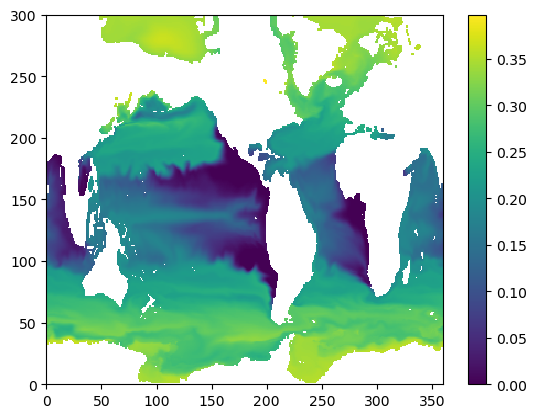

In [30]:
plt.figure()
plt.pcolormesh(sst_ensemble['r1i1p1f1'].isel(time=0))
plt.colorbar()


## take climatology and anomaly

In [ ]:
%%time

# Step 1: Calculate the climatology (mean for each month over all years)
sst_climatology = sst_ensemble.groupby("time.month").mean("time")

# Step 2: Compute the anomaly by subtracting the climatology from the original data
sst_anomalies = sst_ensemble.groupby("time.month") - sst_climatology
sst_anomalies = sst_anomalies.compute()
sst_anomalies


In [ ]:
plt.figure()
plt.pcolormesh(sst_anomalies['r1i1p1f1'].isel(time=-1)*1e3, cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()

print(sst_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## detrend the data

In [ ]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

# Apply the function to each variable in the anomalies dataset
sst_detrended_anomalies = {}

for var in sst_anomalies.data_vars:
    print(f"Processing: {var}")  # Print the current variable name
    
    sst_detrended_anomalies[var] = xr.apply_ufunc(
        detrend_1d,
        sst_anomalies[var],  # Apply to each variable
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[sst_anomalies[var].dtype]
    )

# Convert dictionary back to an xarray Dataset
sst_detrended_anomalies = xr.Dataset(sst_detrended_anomalies)

# Check the detrended dataset
print(sst_detrended_anomalies)


In [ ]:
plt.figure()
plt.pcolormesh(sst_detrended_anomalies['r1i1p1f1'].isel(time=-1)*1e3, cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()

print(sst_detrended_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## retrieve the linear least squares trend

In [ ]:
%%time

# Create a dictionary to store trends for each variable
sst_trends = {}

# Get the time coordinate
dates = sst_anomalies.coords["time"]
time_length = len(dates)

for var in sst_anomalies.data_vars:
    print(f"Processing trend for: {var}")  # Print progress

    # Compute the trend for the current variable
    var_trend = sst_anomalies[var] - sst_detrended_anomalies[var]  # Trend component
    var_trend = (var_trend.sel(time=dates[-1]) - var_trend.sel(time=dates[0])) / time_length * 12 * 10  # Scale per decade

    # Store the trend in the dictionary
    sst_trends[var] = var_trend

# Convert the dictionary into an xarray Dataset
sst_trends = xr.Dataset(sst_trends)

# Print the final trends dataset
print(sst_trends)


In [ ]:
plt.figure()
plt.pcolormesh(sst_trends['r1i1p1f1']*1e6, cmap=cmo.balance, vmin=-0.01, vmax=0.01)
plt.colorbar()

plt.figure()
plt.pcolormesh(sst_trends['r2i1p1f1']*1e6, cmap=cmo.balance, vmin=-0.01, vmax=0.01)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [ ]:
%%time

from scipy.signal import hilbert
import signal
emd = EMD()

years = np.arange(1850+0.5/12, 2014+11.51/12, 1/12)
times = sst_anomalies.coords['time'].values
lats = sst_anomalies.coords['j'].values
lons = sst_anomalies.coords['i'].values
# Get the latitudes and longitudes (2D arrays)
lons_2d = sst_detrended_anomalies.coords["longitude"].values  # (j, i)
lats_2d = sst_detrended_anomalies.coords["latitude"].values  # (j, i)

def find_imf_freq(imfs):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])
    

def set_imfs(imfs, freqs):
    # add IMFs to the master array and merge IMFs into sub-annual, inter-annual, decadal and trend
    lentmp = np.shape(imfs)[0]
    if lentmp > 0:
        mask1 = freqs > 1                       # oscillates with period less than 1 year
        mask2 = (freqs < 1) & (freqs > 0.2)     # oscillates with period between 1 and 5 years
        mask3 = (freqs < 0.2) & (freqs > 0.0)   # oscillates with period greater than 5 years
        out1 = np.mean(imfs[mask1],axis=0)
        out2 = np.mean(imfs[mask2],axis=0)
        out3 = np.mean(imfs[mask3],axis=0)
    else:
        out1 = np.zeros(len(imfs[0,:]))
        out2 = np.zeros(len(imfs[0,:]))
        out3 = np.zeros(len(imfs[0,:]))
    return np.array([out1, out2, out3])


### **Function for Processing Each Grid Point**
def process_grid_point(ix, iy, var):
    time_series = sst_detrended_anomalies[var].isel(i=ix, j=iy).values
    
    if np.any(np.isnan(time_series)):
        return np.zeros((3, len(times)))  # Return zero IMFs for NaN points

    # Compute EMD decomposition
    sstimfs = emd(time_series, max_imf=5)

    # Compute IMF frequencies and classify IMFs
    sst_freqs = find_imf_freq(sstimfs)
    return set_imfs(sstimfs, sst_freqs)


In [ ]:
sst_detrended_anomalies

In [ ]:
%%time

import multiprocessing

# Create a dictionary to store results for each variable
imf_results = {}

# Iterate over each variable in the dataset
for var in list(sst_detrended_anomalies.data_vars.keys())[5:]:
    print(f"Processing variable: {var}")
    sst_imfs = np.zeros((3,len(times),len(lats),len(lons)))

    # Apply multiprocessing to speed up processing across grid points
    with multiprocessing.Pool(processes=16) as pool:  # Adjust based on available CPU cores
        results = pool.starmap(process_grid_point, [(ix, iy, var) for ix in range(len(lons)) for iy in range(len(lats))])
    
    # Convert results to array and reshape
    sst_imfs[:, :, :, :] = np.array(results).reshape(3, len(times), len(lats), len(lons))

    #for ix, lon in enumerate(lons):
    #    if ix % 40 == 0:
    #        print(f"Processing longitude index: {ix}/{len(lons)} for {var}")
    #    for iy, lat in enumerate(lats):
    #        # Extract time series at this grid point
    #        time_series = sst_detrended_anomalies[var].isel(i=ix, j=iy).values
    #        # Skip if NaN values are present
    #        if np.any(np.isnan(time_series)):
    #            continue
    #        # Decompose using EMD (Empirical Mode Decomposition)
    #        sstimfs = emd(time_series, max_imf=5)  # Decomposing into max 5 IMFs
    #        # Determine the frequencies of the IMFs
    #        sst_freqs = find_imf_freq(sstimfs)
    #        # Store the IMFs, merging into categories (sub-annual, inter-annual, etc.)
    #        sst_imfs[:, :, iy, ix] = set_imfs(sstimfs, sst_freqs)

    ### Create Dataset
    name1=f"{var}_chl_imfs"
    name2=f"{var}_chl_anom"
    name3=f"{var}_chl_detr"
    name4=f"{var}_chl_trend"
    # Convert the NumPy array to an xarray DataArray
    imf_da = xr.Dataset(
        {
            name1: (["IMF", "time", "j", "i"], sst_imfs),
            name2: (["time", "j", "i"], sst_anomalies[var].values),
            name3: (["time", "j", "i"], sst_detrended_anomalies[var].transpose("time", "j", "i").values),
            name4: (["j", "i"], sst_trends[var].values),
        },
        coords={
            "IMF": np.arange(1,4,1),  # IMF modes
            "time": times,
            "j": lats,
            "i": lons,
            "longitude": (["j", "i"], lons_2d),  # 2D longitude
            "latitude": (["j", "i"], lats_2d)  # 2D latitude
        },
    )

    ### Save
    file_name = f"{var}_chl_imfs.nc"
    save_dir = "/g/data/es60/pjb581/SPC/data/"
    file_path = os.path.join(save_dir, file_name)
    imf_da.to_netcdf(file_path)
    print(f"Saved {file_name}")

    # Store the IMFs for this variable in the dictionary
    imf_results[var] = sst_imfs

print("Finished processing all variables.")

